In [9]:
# ====== pipsas =======

# implementación
import gymnasium as gym 
import ale_py         
import torch                    
import torch.nn as nn           
import torch.optim as optim     
import numpy as np             
import random                   
from collections import deque  
from torchvision import transforms 

# graficas
import matplotlib.pyplot as plt     

# guardar y cargar 
import os                       

In [ ]:
# ====== max rendimiento ======

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# ====== normalizar el espacio ======

normaliza = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((84, 84)),
    transforms.ToTensor()
])

In [12]:
# ====== red neuronal ======

class QN(nn.Module):
    def __init__(self, action_size):
        super(QN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [13]:
# ====== agente ======

class QNAgent:
    def __init__(self, action_size):
        self.action_size = action_size
        self.memory = deque(maxlen=10000) 
        self.batch_size = 32
        self.gamma = 0.99    # descuento 
        self.tau = 1e-3      # soft update de la red target
        self.lr = 1e-4       # tasa de aprendizaje

        # red neuronal
        self.politica_net = QN(action_size).to(device)
        # red target
        self.target_net = QN(action_size).to(device)

    
        self.optimizer = optim.Adam(self.politica_net.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

        self.act_target_net()

    # guardar las transiciones
    def memoria(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # política epsilon-greedy
    def act(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.politica_net(state)
        return q_values.argmax().item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.stack(states)).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(np.stack(next_states)).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        current_q = self.politica_net(states).gather(1, actions)
        next_actions = torch.argmax(self.politica_net(next_states), dim=1, keepdim=True)
        next_q = self.target_net(next_states).gather(1, next_actions)

        target_q = rewards + (1 - dones) * self.gamma * next_q
        loss = self.criterion(current_q, target_q.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    # actualizar la red target
    def act_target_net(self):
        self.target_net.load_state_dict(self.politica_net.state_dict())

    # guargar el modelo
    def save(self, filename):
        torch.save(self.politica_net.state_dict(), filename)

    # cargar el modelo (de haber uno claro)
    def load(self, filename):
        self.politica_net.load_state_dict(torch.load(filename, map_location=device))
        self.politica_net.eval()
    

In [14]:
# ====== normaliza los frames ======

def normaliza_frame(frame):
    frame = normaliza(frame).squeeze(0)
    return frame.numpy()

In [ ]:
# ====== entrenamiento ======

env = gym.make('ALE/Breakout-v5', render_mode=None, frameskip=1)
num_actions = env.action_space.n
print(f"Acciones posibles: {num_actions}")

agent = QNAgent(num_actions)

# 🔥 Punto de guardado
checkpoint_path = 'ddqn_breakout.pth'
if os.path.exists(checkpoint_path):
    print("✅ Checkpoint encontrado. Cargando...")
    agent.load(checkpoint_path)
else:
    print("🚀 No hay checkpoint. Empezando desde cero...")

Acciones posibles: 4
🚀 No hay checkpoint. Empezando desde cero...


In [16]:
# ====== datos del entrenamiento ======
epsodios = 200
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.995
target_update_freq = 10

rewards_h = []

In [17]:
# ====== implementación del entrenamiento ======

for ep in range(epsodios):
    obs, _ = env.reset()
    frame = normaliza_frame(obs)
    state_stack = np.stack([frame] * 4, axis=0)

    total_reward = 0
    done = False

    while not done:
        action = agent.act(state_stack, epsilon)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        next_frame = normaliza_frame(next_obs)
        next_state_stack = np.append(state_stack[1:], [next_frame], axis=0)

        agent.memoria(state_stack, action, reward, next_state_stack, done)
        state_stack = next_state_stack
        total_reward += reward

        agent.replay()

    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    rewards_h.append(total_reward)

    if ep % target_update_freq == 0:
        agent.act_target_net()

    # guardar cada 25 episodios
    if (ep + 1) % 25 == 0:
        agent.save(checkpoint_path)
        print(f"💾 Checkpoint guardado en episodio {ep + 1}")

    print(f"Episodio {ep + 1}, Recompensa total: {total_reward}, Epsilon: {epsilon:.3f}")


Episodio 1, Recompensa total: 0.0, Epsilon: 0.995
Episodio 2, Recompensa total: 0.0, Epsilon: 0.990
Episodio 3, Recompensa total: 0.0, Epsilon: 0.985
Episodio 4, Recompensa total: 3.0, Epsilon: 0.980
Episodio 5, Recompensa total: 0.0, Epsilon: 0.975
Episodio 6, Recompensa total: 1.0, Epsilon: 0.970
Episodio 7, Recompensa total: 2.0, Epsilon: 0.966
Episodio 8, Recompensa total: 5.0, Epsilon: 0.961
Episodio 9, Recompensa total: 1.0, Epsilon: 0.956
Episodio 10, Recompensa total: 2.0, Epsilon: 0.951
Episodio 11, Recompensa total: 1.0, Epsilon: 0.946
Episodio 12, Recompensa total: 3.0, Epsilon: 0.942
Episodio 13, Recompensa total: 0.0, Epsilon: 0.937
Episodio 14, Recompensa total: 3.0, Epsilon: 0.932
Episodio 15, Recompensa total: 0.0, Epsilon: 0.928
Episodio 16, Recompensa total: 1.0, Epsilon: 0.923
Episodio 17, Recompensa total: 2.0, Epsilon: 0.918
Episodio 18, Recompensa total: 4.0, Epsilon: 0.914
Episodio 19, Recompensa total: 2.0, Epsilon: 0.909
Episodio 20, Recompensa total: 1.0, Epsi

In [18]:
# ====== guardar el último modelo ======

agent.save(checkpoint_path)
print("Entrenamiento terminado. Modelo guardado.")

Entrenamiento terminado. Modelo guardado.


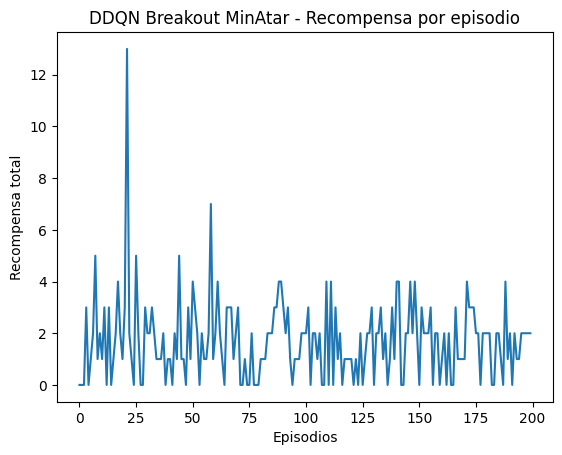

In [19]:
# ====== grafica de las recompensas ======

plt.plot(rewards_h)
plt.xlabel('Episodios')
plt.ylabel('Recompensa total')
plt.title('DDQN Breakout MinAtar - Recompensa por episodio')
plt.show()

In [ ]:
env.close()